# Neural Style Transfer
The idea behind this project is to make a program repaint a content image in the style of a style image.  
let's say I want to have my picture with my boy Hisham to be repainted in the style of starry night.  
<img src="images/content.jpg" width="300px" style="float: left; margin-right: 30px;" />
<img src="images/style.jpg" width="300px" style="float: left;" />  



# Plan of attack
This is not a very straight forward problem so let me break it down for you.  
We need to extract features out of these images, we don't want to have the exact pixel values in them, we just need the features.  
To extract these features we could ( and will ) use a pretrained CNN to encode these images into feature maps.  
Then we need to figure out a way to mathematically model the style of the style image.  
Then we need to define a function that models the content loss (a metric that measures how different the image in hand is from the content image)
Then we need to define a function that models the style loss (a metric that measures how different the style of the image in hand is from the style of the style image)

**To sum up**
* Use a pretrained CNN to convert images to feature maps
* Define a function to model the style of an image given its feature map
* Define a function to calculate the content loss $ J_{content} $
* Define a function to calculate the style loss $ J_{style} $
* Minimize the sum of those two loss functions $ min (J), \quad J = \alpha J_{content} + \beta J_{style} $

**NOTE**
> The optimization variable this time is not going to be the weights of the CNN, those will remain unchanged
> it will rather be the pixel data of the target image that you want to create.

In [9]:
## importing modules
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.image as mpimg
import PIL.Image
from tqdm import tqdm
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False
import functools
import IPython.display as display

In [19]:
def load_img(path_to_img):
    max_dim = 512
    # read file
    img = tf.io.read_file(path_to_img)
    # decode with three channels RGB
    img = tf.image.decode_image(img, channels=3)
    # convert the datatype of tensor to float32
    img = tf.image.convert_image_dtype(img, tf.float32)
    # get the size of the image as float32
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    # get the longer dimension
    long_dim = max(shape)
    # define a scaling factor
    scale = max_dim / long_dim
    # scale the image by that factor and save the new shape as int32
    # this keeps the aspect ratio
    new_shape = tf.cast(shape * scale, tf.int32)
    # resize the image to the new shape
    img = tf.image.resize(img, new_shape)
    # make it a batch
    img = img[tf.newaxis, :]
    return img

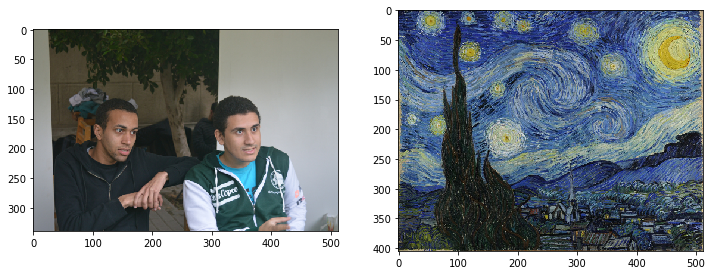

In [20]:
# let's load the images
content_image = load_img("images/content.jpg")
style_image = load_img("images/style.jpg")

plt.subplot(1, 2, 1)
plt.imshow(content_image[0])

plt.subplot(1, 2, 2)
plt.imshow(style_image[0])

## Getting a pretrained CNN
The `tensorflow.keras.applications` module has a lot of powerful CNNs that we can use.  
I'll be using the VGG19 network in this notebook but feel free to use whatever you want.

In [2]:
vgg = tf.keras.applications.VGG19(include_top=False, weights="imagenet")
# The top is the last layer in the network, this is used for classification so we don't need it

In [3]:
# the feature maps are extracted from the convolutional layers of the model
# let's find out how they're named
vgg.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

Now let's take some of those names and store them in two lists
* One will be hold content layers from which we extract feature maps to calculate the content loss
* The other will hold the style layers form which we extract feature maps to calculate the style loss

In [5]:
# you can change these if you want, playing around is never bad ;)
content_layers = ["block5_conv4"]
style_layers = [
    "block1_conv1",
    "block2_conv2",
    "block3_conv2",
    "block4_conv3",
    "block5_conv3",
]
no_content = len(style_layers)
no_style = len(content_layers)

Now let's define a model which has the inputs of the vgg model and outputs of those layers

In [12]:
outputs = [vgg.get_layer(name).output for name in style_layers + content_layers]
extractor = tf.keras.Model(inputs=vgg.inputs, outputs=outputs)
extractor.trainable = False

In [23]:
# let's take it for a spin
outputs = extractor(content_image)
len(outputs)

6

### Nice
We now have six output for six layers, five for style and one for content.  
Getting feature maps ... check.


## The Gram matrix
We need a way to model the style, the gram matrix does that job well.  
First you need to understand how the style is defined, it is defined as the corelation between features.  
The gram matrix calculates just that and implementing it is very easy.  
For any layer $ l $ with output $ F(x) $ with dimensions $ i, j, c $ also modeled as $ i, j, d $, The gram matrix G is defined as: 
  
  
$$ G_{cd}^l = \frac{\sum_{ij} F_{ij}^l(x) * F_{ij}^l(x)}{IJ} $$  

You can calculate that in tensorflow using the beautiful [`tensorflow.linalg.einsum`](https://www.tensorflow.org/api_docs/python/tf/einsum) function

In [24]:
def gram_matrix(input_tensor):
    # the b dimension is just the batch, don't worry about it
    result = tf.linalg.einsum("bijc,bijd->bcd", input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result / num_locations
    

In [27]:
# the first layer in the outputs is block1_conv1
# this one has output shape of (None, None, None, 64)
# its gram matrix should have shape (None, 64, 64) with none being the batches (just 1)
g = gram_matrix(outputs[0])
g.shape

TensorShape([1, 64, 64])

### Looking good
Now we can get the style of any image.  
Let's dive into the next step